In [12]:
# ======================================================
# 📚 Import Required Libraries
# ======================================================
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os


In [13]:
import os
import zipfile
from google.colab import files

# Step 1: Upload kaggle.json
files.upload()

# Step 2: Set up Kaggle API credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Step 3: Download the dataset
!kaggle datasets download -d farukalam/tomato-leaf-diseases-detection-computer-vision

# Step 4: Create a local directory for the dataset
os.makedirs("/content/tomato_dataset", exist_ok=True)

# Step 5: Extract the zip file here
with zipfile.ZipFile("tomato-leaf-diseases-detection-computer-vision.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/tomato_dataset")


Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/farukalam/tomato-leaf-diseases-detection-computer-vision
License(s): CC0-1.0
tomato-leaf-diseases-detection-computer-vision.zip: Skipping, found more recently modified local copy (use --force to force download)


In [14]:
# ======================================================
# 📁 Define Dataset Paths
# ======================================================
train_path = '/content/tomato_dataset/train'
valid_path = '/content/tomato_dataset/valid'
test_path = '/content/tomato_dataset/test'

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

print("Train Path:", train_path)
print("Validation Path:", valid_path)


Train Path: /content/tomato_dataset/train
Validation Path: /content/tomato_dataset/valid


In [15]:
# ======================================================
# 🧠 Data Generators with Stronger Augmentation
# ======================================================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_set = test_datagen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_set = test_datagen.flow_from_directory(
    test_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("✅ Data generators ready!")

Found 645 images belonging to 2 classes.
Found 61 images belonging to 2 classes.
Found 31 images belonging to 2 classes.
✅ Data generators ready!


In [16]:
# ======================================================
# 🧩 Build Model with Dropout Layers
# ======================================================
base_model = VGG16(input_shape=IMAGE_SIZE + (3,), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(training_set.num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,692,098 (105.64 MB)

 Trainable params: 12,977,410 (49.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [17]:
# ======================================================
# 🚀 Train Model with EarlyStopping & ReduceLROnPlateau
# ======================================================
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

history = model.fit(
    training_set,
    validation_data=validation_set,
    epochs=30,
    steps_per_epoch=len(training_set),
    validation_steps=len(validation_set),
    callbacks=[early_stop, reduce_lr]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 647ms/step - accuracy: 0.8398 - loss: 0.3012 - val_accuracy: 1.0000 - val_loss: 1.9543e-09 - learning_rate: 1.0000e-04
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 497ms/step - accuracy: 1.0000 - loss: 9.3818e-07 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 483ms/step - accuracy: 1.0000 - loss: 2.7165e-07 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 1.0000 - loss: 1.4527e-07
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 486ms/step - accuracy: 1.0000 - loss: 1.4677e-07 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 488ms/step - accuracy: 1.0000 - loss: 2.7962e-06 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 2.0000e-05
Epoch 6/30
21/21 ━━━━━━

In [18]:
# ======================================================
# 📊 Evaluate Model
# ======================================================
val_loss, val_acc = model.evaluate(validation_set)
print(f"✅ Validation Accuracy: {val_acc*100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 1.0000 - loss: 0.0000e+00
✅ Validation Accuracy: 100.00%
Validation Loss: 0.0000


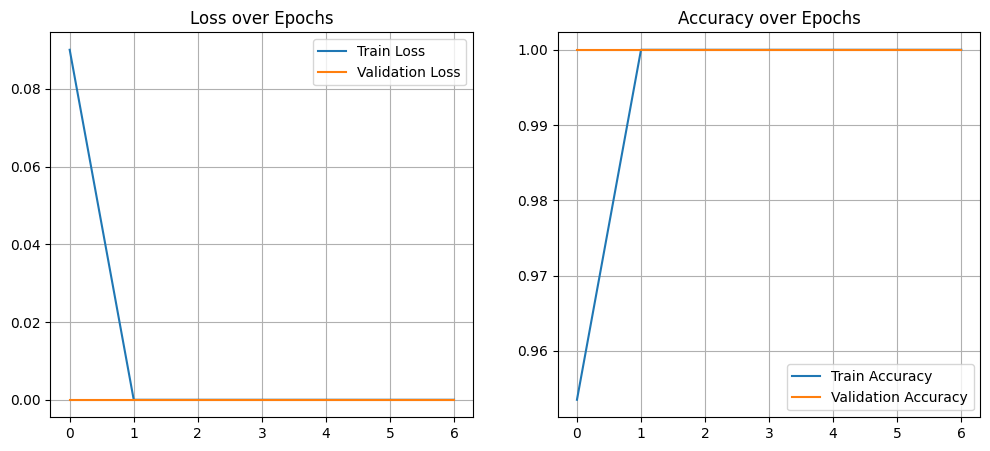

In [19]:
# ======================================================
# 📈 Plot Training and Validation Curves
# ======================================================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.show()


In [20]:
## Create the true test set generator
# We use the same 'test_datagen' (only rescaling)
test_set = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # <-- IMPORTANT: Do not shuffle test data
)

Found 31 images belonging to 2 classes.


In [21]:
## 🧪 Final Model Evaluation
# (The 'model' object is already the best version thanks to EarlyStopping)
print("Evaluating model on the true test set...")
results = model.evaluate(test_set)

print(f"\nTest Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

Evaluating model on the true test set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step - accuracy: 1.0000 - loss: 0.0000e+00

Test Loss: 0.0
Test Accuracy: 1.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Classification Report:
              precision    recall  f1-score   support

      images       1.00      1.00      1.00        31

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31

Confusion Matrix:


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 1, does not match size of target_names, 2
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


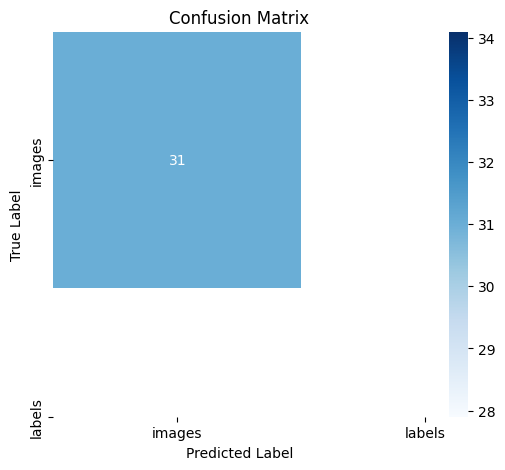

In [22]:
## 📊 Classification Report & Confusion Matrix
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get predictions
y_pred_probs = model.predict(test_set)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true_classes = test_set.classes

# Get class names
class_names = list(test_set.class_indices.keys())

# Classification Report
print("Classification Report:")
# Explicitly provide the unique labels present in y_true_classes
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names, labels=np.unique(y_true_classes)))

# Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()